Accuracy: 0.9938330170777988

Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99      1198
           1       1.00      0.99      0.99       910

    accuracy                           0.99      2108
   macro avg       0.99      0.99      0.99      2108
weighted avg       0.99      0.99      0.99      2108



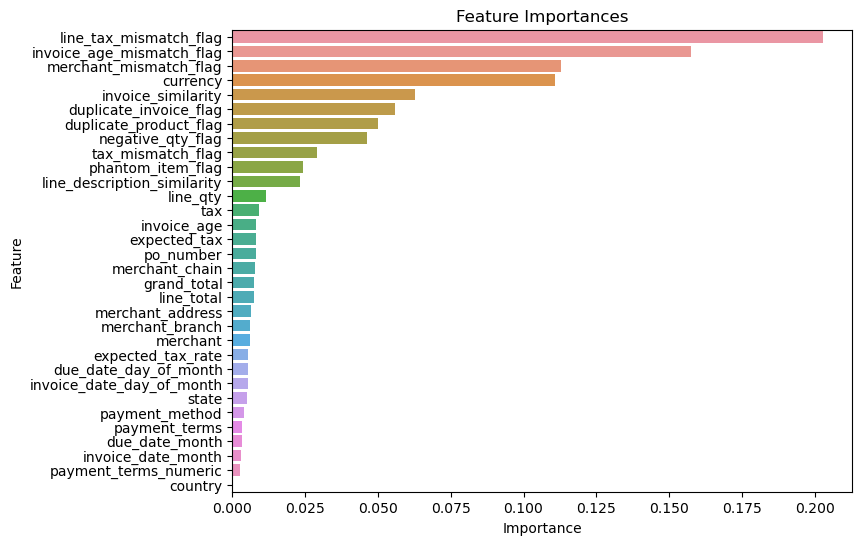

AUC: 0.9931226953347153


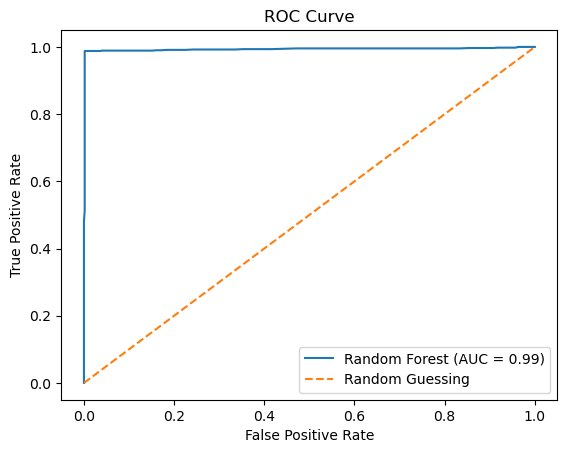

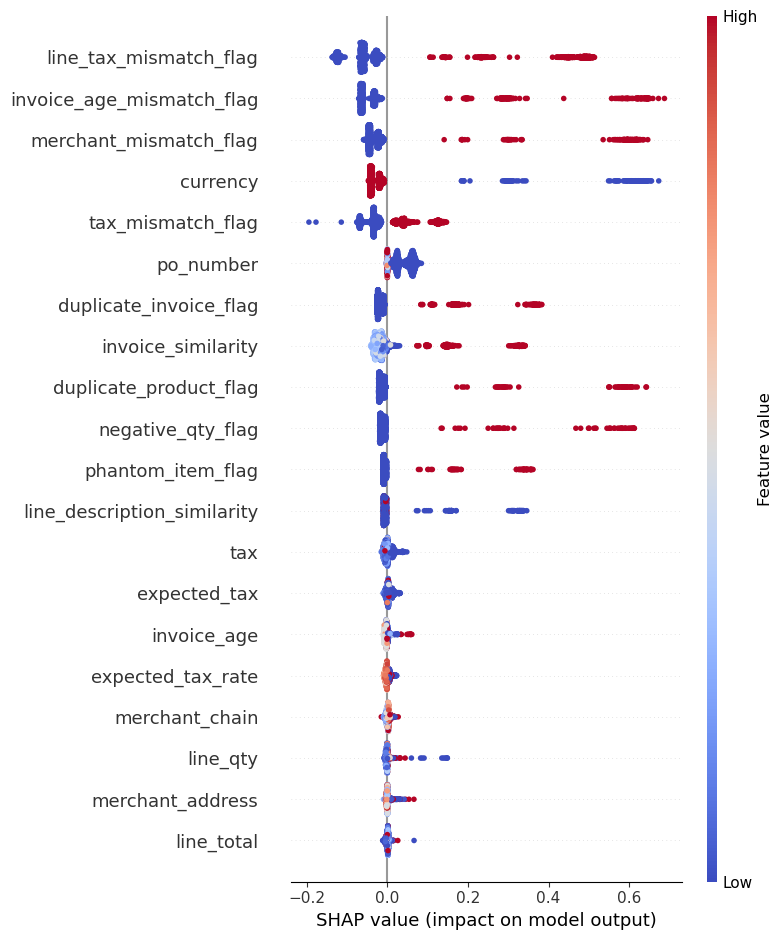

<Figure size 640x480 with 0 Axes>

In [28]:
import pandas as pd
import numpy as np
from feature_engine import datetime as fe_datetime
from sklearn import ensemble, metrics, preprocessing
import shap
import matplotlib.pyplot as plt
import seaborn as sns


# ---------------------
# 1) Load & Prep Data
# ---------------------
df_train = pd.read_parquet("train_df.parquet", engine="pyarrow")
df_test = pd.read_parquet("test_df.parquet", engine="pyarrow")

X_train = df_train.drop(["is_anomalous", "_ANOMALY_TYPES_DROP_BEFORE_TRAINING_"], axis=1, errors="ignore")
y_train = df_train["is_anomalous"]
X_test = df_test.drop(["is_anomalous", "_ANOMALY_TYPES_DROP_BEFORE_TRAINING_"], axis=1, errors="ignore")
y_test = df_test["is_anomalous"]

# Identify categorical and datetime columns
label_cols = [col for col in X_train.columns if X_train[col].dtype == "object"]
datetime_cols = [col for col in X_train.columns if X_train[col].dtype == "datetime64[ns]"]

# Label encode each categorical column
for col in label_cols:
    encoder = preprocessing.OrdinalEncoder(
        handle_unknown="use_encoded_value", 
        unknown_value=-1
    )
    X_train[[col]] = encoder.fit_transform(X_train[[col]].astype(str))
    X_test[[col]] = encoder.transform(X_test[[col]].astype(str))

# Encode datetime columns
for col in datetime_cols:
    dtfs = fe_datetime.DatetimeFeatures(features_to_extract=["month", "day_of_month"])
    X_train = pd.concat(
        [X_train.drop(col, axis=1), pd.DataFrame(dtfs.fit_transform(X_train[[col]]))],
        axis=1,
    )
    X_test = pd.concat(
        [X_test.drop(col, axis=1), pd.DataFrame(dtfs.transform(X_test[[col]]))], 
        axis=1
    )

# --------------------------------------
# 2) Train Model & Basic Performance
# --------------------------------------
model = ensemble.RandomForestClassifier(n_estimators=500, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", metrics.classification_report(y_test, y_pred))

# --------------------------------------
# 3) Feature Importances
# --------------------------------------
importances = model.feature_importances_
feature_names = X_train.columns
feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values('importance', ascending=False)

feature_importance_df = feature_importance_df.sort_values("importance", ascending=False)

plt.figure(figsize=(8, 6))
sns.barplot(
    data=feature_importance_df,
    x="importance",
    y="feature",
    orient="h"  # horizontal bars
)

plt.title("Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

# --------------------------------------
# 4) ROC Curve
# --------------------------------------
y_proba = model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_proba)
roc_auc = metrics.auc(fpr, tpr)

print("AUC:", roc_auc)

plt.figure()
plt.plot(fpr, tpr, label='Random Forest (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], linestyle='--', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()


# --------------------------------------
# 5) SHAP value
# --------------------------------------
rf_explainer = shap.TreeExplainer(model)            # trained RandomForest
shap_vals    = rf_explainer.shap_values(X_test)     # list[2] for binary

shap_vals = shap_vals[:, :, 1] # class‑1 only
# shap_vals shape: (n_samples, n_features)

mean_abs = np.abs(shap_vals).mean(axis=0)           # size = n_features
order    = np.argsort(-mean_abs)                    # descending

# Re‑order SHAP matrix and DataFrame columns
shap_sorted = shap_vals[:, order]
X_sorted    = X_test.iloc[:, order]

# Optional: feature names in sorted order
sorted_names = X_sorted.columns.tolist()

shap.summary_plot(
    shap_sorted,
    X_sorted,
    feature_names=sorted_names,
    plot_type="dot",
    cmap="coolwarm",       # blue ↔ red
    color_bar=True,
    show=True
)

plt.tight_layout()
plt.show()